# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

In [2]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [5]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

To visualize the training data, I will use PCA to find the first two principal components of the node vectors and color them by class to see how the differences between classes can be seen. 

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


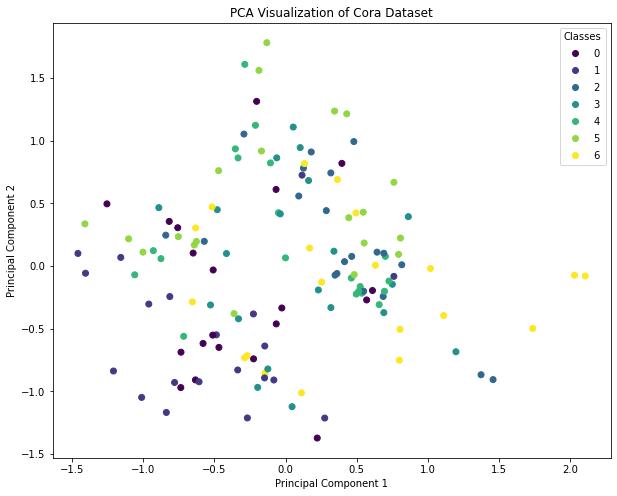

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

features = dataset.data.x.numpy()
labels = dataset.data.y.numpy()

features_train = features[dataset.data.train_mask]
labels_train = labels[dataset.data.train_mask]

pca = PCA(n_components = 2)
features_2d = pca.fit_transform(features_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_train)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Visualization of Cora Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Visualizing the node vectors in this way doesn't reveal any obvious patterns in the data but some are there nonetheless. There is a cluster of yellow points (class 6) in the bottom right of the graph and group of light green points (class 5) all residing at or above 0 on the PC 2 axis. There is also a big group of purple points (class 0) in the bottom left, and a tight cluster of teal points (class 4) around the (0.5, -0.25) point. This visualization only involves the content of the node vectors containing words, so there isn't any information involving graph structure, but it is a good visualization to see how the node embeddings differ among classes.

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

* **Question 2 (1 pt):** What's "weight decay"?

**Answer**: Weight decay is the strength of the regularization term in L2 regularization. L2 regularization adds the squared sum of the weights multiplied by a strength term, lambda. The larger the lambda, the larger the penalty on each loss step. The weight_decay parameter in the optimizer is lambda, and it can be adjusted based on the number of parameters and the amount of regularization needed for the model.

In [15]:
# Defining a training step
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test(model):
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [17]:
# Run one iteration
train(model, optimizer)
acc = test(model)
print(f'Accuracy: {acc:.4f}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy: 0.5230


In [18]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train(model, optimizer)
    accuracy.append(test(model))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.618
Accuracy on epoch 2: 0.657
Accuracy on epoch 3: 0.664
Accuracy on epoch 4: 0.673
Accuracy on epoch 5: 0.681
Accuracy on epoch 6: 0.684
Accuracy on epoch 7: 0.688
Accuracy on epoch 8: 0.693
Accuracy on epoch 9: 0.696
Accuracy on epoch 10: 0.699
Accuracy on epoch 11: 0.696
Accuracy on epoch 12: 0.696
Accuracy on epoch 13: 0.696
Accuracy on epoch 14: 0.697
Accuracy on epoch 15: 0.698
Accuracy on epoch 16: 0.697
Accuracy on epoch 17: 0.699
Accuracy on epoch 18: 0.699
Accuracy on epoch 19: 0.699
Accuracy on epoch 20: 0.701
Accuracy on epoch 21: 0.7
Accuracy on epoch 22: 0.701
Accuracy on epoch 23: 0.699
Accuracy on epoch 24: 0.699
Accuracy on epoch 25: 0.7
Accuracy on epoch 26: 0.701
Accuracy on epoch 27: 0.703
Accuracy on epoch 28: 0.705
Accuracy on epoch 29: 0.705
Accuracy on epoch 30: 0.704
Accuracy on epoch 31: 0.703
Accuracy on epoch 32: 0.703
Accuracy on epoch 33: 0.704
Accuracy on epoch 34: 0.704
Accuracy on epoch 35: 0.704
Accuracy on epoch 36: 0.704
Accur

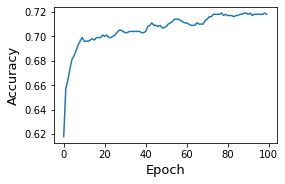

In [19]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


Good luck! :)

#### Question 3: 
Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

In order to quantify accuracy across classes, I will use a confusion matrix. This will give me a 7x7 table, with one axis being the correct label and the other being the predicted label. The diagonal of the table will be the correctly predicted labels, and the other boxes will be incorrect predictions, sorted by which incorrect prediction was made for each correct label.

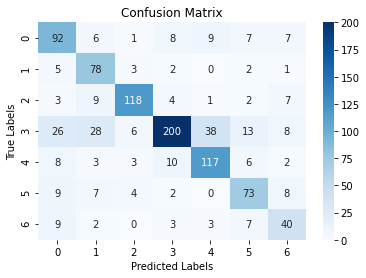

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

out = model(dataset.data)
pred = out.argmax(dim=1)

true_labels = dataset.data.y[dataset.data.test_mask].numpy()
pred_labels = pred[dataset.data.test_mask].numpy()
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(range(7)))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy Label 0: 0.71

Accuracy Label 1: 0.86

Accuracy Label 2: 0.82

Accuracy Label 3: 0.63

Accuracy Label 4: 0.79

Accuracy Label 5: 0.71

Accuracy Label 6: 0.63

The accuracy of the model across classes varies significantly. Accuracy on label 1 was the highest at 86%, and lowest on labels 3 and 6 at 63%. The most incorrect predictions occurred on label 3, but the most correct labels for any class was also label 3. Label 3 was also by far the most seen in the test set, so it makes sense it produced the highest number of correct predictions across the classes, but predictions on it were among the least accurate. This could be because since there were so many label 3's in the test set, the training set didn't have as many, but label 3 could also be the most frequent in the dataset in general. Conversely, label 6 likely produced a low accuracy because it could be the least frequent class in the dataset, as it is in the test set. 

#### Question 4:
Compare this GraphSage with models from Weekly Assignment 2.

**Answer:** The structure of this model is very similar to the GCN we trained in Assignment 2. It defines convolutional layers to perform message passing and create embeddings for classification. It also uses a component of the random walk GNN that we used in Assignment 2 to represent graph structure. However, in terms of accuracy, the initial model trained in the starter code performed worse than the GCN from the last assignment. The initial GraphSAGE model only reached 71.7% accuracy, while the initial GCN (along with many of the other GCNs with modifications) reached between 78 and 83 percent accuracy. The GCNs from assignment 2 had 2 convolutional layers, however, while the initial model in this assignment only has 1. I would expect accuracy on the GraphSAGE to increase when we add another layer to the model.

#### Question 5:

Change the aggregation function to max. What's the default?

The default aggregation function for the SAGEConv() function is mean pooling. In the code below, I will change the aggregation function to max pooling and run it. I don't know what I expect to happen. Let's see.

In [6]:
class GraphSAGEMax(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [7]:
model_max = GraphSAGEMax(dataset.num_node_features, dataset.num_classes)
optimizer_max = torch.optim.Adam(model_max.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_max = []
for epoch in range(100):
    train(model_max, optimizer_max)
    accuracy_max.append(test(model_max))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_max[-1]}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.487
Accuracy on epoch 2: 0.615
Accuracy on epoch 3: 0.678
Accuracy on epoch 4: 0.712
Accuracy on epoch 5: 0.722
Accuracy on epoch 6: 0.723
Accuracy on epoch 7: 0.732
Accuracy on epoch 8: 0.731
Accuracy on epoch 9: 0.728
Accuracy on epoch 10: 0.729
Accuracy on epoch 11: 0.725
Accuracy on epoch 12: 0.72
Accuracy on epoch 13: 0.718
Accuracy on epoch 14: 0.717
Accuracy on epoch 15: 0.716
Accuracy on epoch 16: 0.714
Accuracy on epoch 17: 0.713
Accuracy on epoch 18: 0.712
Accuracy on epoch 19: 0.711
Accuracy on epoch 20: 0.71
Accuracy on epoch 21: 0.709
Accuracy on epoch 22: 0.71
Accuracy on epoch 23: 0.71
Accuracy on epoch 24: 0.709
Accuracy on epoch 25: 0.707
Accuracy on epoch 26: 0.707
Accuracy on epoch 27: 0.708
Accuracy on epoch 28: 0.707
Accuracy on epoch 29: 0.707
Accuracy on epoch 30: 0.707
Accuracy on epoch 31: 0.707
Accuracy on epoch 32: 0.707
Accuracy on epoch 33: 0.707
Accuracy on epoch 34: 0.705
Accuracy on epoch 35: 0.706
Accuracy on epoch 36: 0.704
Accur

In this case, max pooling as the aggregation function slightly improved the test accuracy over mean pooling, increasing it from 71.7% to 72.6% after 100 epochs. The max aggregation function must have done a better job capturing features during message passing that led to a higher accuracy on the test dataset.

#### Question 6:

Add one more layer to the model and investigate the performance change.

For this model, I need to define a dimension for the hidden layer. I will start at 16, then increase it to 64, 128, 256, and 512 to see which performs the best. Increasing the hidden layer exponentially will do the best job covering the entrire range of possibilities.

In [10]:
class GraphSAGE2Layer(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hid_channels)
        self.conv2 = SAGEConv(hid_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [11]:
model_2L = GraphSAGE2Layer(dataset.num_node_features, 16, dataset.num_classes)
optimizer_2L = torch.optim.Adam(model_2L.parameters(), lr=0.01, weight_decay=5e-4)

In [22]:
accuracy_2L = []
for epoch in range(100):
    train(model_2L, optimizer_2L)
    accuracy.append(test(model_2L))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.468
Accuracy on epoch 2: 0.427
Accuracy on epoch 3: 0.397
Accuracy on epoch 4: 0.441
Accuracy on epoch 5: 0.503
Accuracy on epoch 6: 0.569
Accuracy on epoch 7: 0.65
Accuracy on epoch 8: 0.707
Accuracy on epoch 9: 0.743
Accuracy on epoch 10: 0.755
Accuracy on epoch 11: 0.751
Accuracy on epoch 12: 0.747
Accuracy on epoch 13: 0.741
Accuracy on epoch 14: 0.733
Accuracy on epoch 15: 0.721
Accuracy on epoch 16: 0.712
Accuracy on epoch 17: 0.696
Accuracy on epoch 18: 0.689
Accuracy on epoch 19: 0.687
Accuracy on epoch 20: 0.685
Accuracy on epoch 21: 0.686
Accuracy on epoch 22: 0.688
Accuracy on epoch 23: 0.688
Accuracy on epoch 24: 0.691
Accuracy on epoch 25: 0.697
Accuracy on epoch 26: 0.701
Accuracy on epoch 27: 0.703
Accuracy on epoch 28: 0.709
Accuracy on epoch 29: 0.713
Accuracy on epoch 30: 0.715
Accuracy on epoch 31: 0.718
Accuracy on epoch 32: 0.722
Accuracy on epoch 33: 0.726
Accuracy on epoch 34: 0.727
Accuracy on epoch 35: 0.726
Accuracy on epoch 36: 0.729
Ac

The GraphSAGE with an additional layer performed significantly better than the initial model, reaching a test accuracy of 79.3% after 100 epochs. The additional layer improved message passing and allowed the model to correctly classify more test nodes. While the computational complexity increased, the GPU did a great job of running the training in a very short amount of time.

In [25]:
model_2L = GraphSAGE2Layer(dataset.num_node_features, 64, dataset.num_classes)
optimizer_2L = torch.optim.Adam(model_2L.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_2L = []
for epoch in range(100):
    train(model_2L, optimizer_2L)
    accuracy.append(test(model_2L))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.661
Accuracy on epoch 2: 0.693
Accuracy on epoch 3: 0.717
Accuracy on epoch 4: 0.746
Accuracy on epoch 5: 0.761
Accuracy on epoch 6: 0.767
Accuracy on epoch 7: 0.772
Accuracy on epoch 8: 0.777
Accuracy on epoch 9: 0.778
Accuracy on epoch 10: 0.782
Accuracy on epoch 11: 0.785
Accuracy on epoch 12: 0.787
Accuracy on epoch 13: 0.786
Accuracy on epoch 14: 0.79
Accuracy on epoch 15: 0.791
Accuracy on epoch 16: 0.79
Accuracy on epoch 17: 0.79
Accuracy on epoch 18: 0.789
Accuracy on epoch 19: 0.788
Accuracy on epoch 20: 0.788
Accuracy on epoch 21: 0.789
Accuracy on epoch 22: 0.788
Accuracy on epoch 23: 0.791
Accuracy on epoch 24: 0.792
Accuracy on epoch 25: 0.792
Accuracy on epoch 26: 0.792
Accuracy on epoch 27: 0.792
Accuracy on epoch 28: 0.791
Accuracy on epoch 29: 0.793
Accuracy on epoch 30: 0.79
Accuracy on epoch 31: 0.791
Accuracy on epoch 32: 0.792
Accuracy on epoch 33: 0.791
Accuracy on epoch 34: 0.792
Accuracy on epoch 35: 0.791
Accuracy on epoch 36: 0.79
Accura

The model performed better with a hidden dimension of 64! Another observation is that the test accuracy plateaued much sooner than the model with a hidden dimension of 16

In [26]:
model_2L = GraphSAGE2Layer(dataset.num_node_features, 128, dataset.num_classes)
optimizer_2L = torch.optim.Adam(model_2L.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_2L = []
for epoch in range(100):
    train(model_2L, optimizer_2L)
    accuracy.append(test(model_2L))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.719
Accuracy on epoch 2: 0.764
Accuracy on epoch 3: 0.778
Accuracy on epoch 4: 0.78
Accuracy on epoch 5: 0.778
Accuracy on epoch 6: 0.776
Accuracy on epoch 7: 0.773
Accuracy on epoch 8: 0.77
Accuracy on epoch 9: 0.77
Accuracy on epoch 10: 0.774
Accuracy on epoch 11: 0.772
Accuracy on epoch 12: 0.772
Accuracy on epoch 13: 0.768
Accuracy on epoch 14: 0.765
Accuracy on epoch 15: 0.763
Accuracy on epoch 16: 0.762
Accuracy on epoch 17: 0.76
Accuracy on epoch 18: 0.759
Accuracy on epoch 19: 0.755
Accuracy on epoch 20: 0.752
Accuracy on epoch 21: 0.752
Accuracy on epoch 22: 0.751
Accuracy on epoch 23: 0.752
Accuracy on epoch 24: 0.749
Accuracy on epoch 25: 0.748
Accuracy on epoch 26: 0.747
Accuracy on epoch 27: 0.75
Accuracy on epoch 28: 0.749
Accuracy on epoch 29: 0.75
Accuracy on epoch 30: 0.75
Accuracy on epoch 31: 0.75
Accuracy on epoch 32: 0.747
Accuracy on epoch 33: 0.748
Accuracy on epoch 34: 0.75
Accuracy on epoch 35: 0.756
Accuracy on epoch 36: 0.756
Accuracy o

In [27]:
model_2L = GraphSAGE2Layer(dataset.num_node_features, 256, dataset.num_classes)
optimizer_2L = torch.optim.Adam(model_2L.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_2L = []
for epoch in range(100):
    train(model_2L, optimizer_2L)
    accuracy.append(test(model_2L))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.786
Accuracy on epoch 2: 0.794
Accuracy on epoch 3: 0.778
Accuracy on epoch 4: 0.777
Accuracy on epoch 5: 0.773
Accuracy on epoch 6: 0.777
Accuracy on epoch 7: 0.773
Accuracy on epoch 8: 0.775
Accuracy on epoch 9: 0.771
Accuracy on epoch 10: 0.768
Accuracy on epoch 11: 0.766
Accuracy on epoch 12: 0.763
Accuracy on epoch 13: 0.76
Accuracy on epoch 14: 0.758
Accuracy on epoch 15: 0.753
Accuracy on epoch 16: 0.752
Accuracy on epoch 17: 0.751
Accuracy on epoch 18: 0.747
Accuracy on epoch 19: 0.742
Accuracy on epoch 20: 0.738
Accuracy on epoch 21: 0.734
Accuracy on epoch 22: 0.732
Accuracy on epoch 23: 0.73
Accuracy on epoch 24: 0.726
Accuracy on epoch 25: 0.723
Accuracy on epoch 26: 0.72
Accuracy on epoch 27: 0.72
Accuracy on epoch 28: 0.728
Accuracy on epoch 29: 0.726
Accuracy on epoch 30: 0.731
Accuracy on epoch 31: 0.741
Accuracy on epoch 32: 0.741
Accuracy on epoch 33: 0.745
Accuracy on epoch 34: 0.744
Accuracy on epoch 35: 0.754
Accuracy on epoch 36: 0.757
Accur

In [28]:
model_2L = GraphSAGE2Layer(dataset.num_node_features, 512, dataset.num_classes)
optimizer_2L = torch.optim.Adam(model_2L.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_2L = []
for epoch in range(100):
    train(model_2L, optimizer_2L)
    accuracy.append(test(model_2L))
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.774
Accuracy on epoch 2: 0.789
Accuracy on epoch 3: 0.79
Accuracy on epoch 4: 0.778
Accuracy on epoch 5: 0.766
Accuracy on epoch 6: 0.759
Accuracy on epoch 7: 0.751
Accuracy on epoch 8: 0.745
Accuracy on epoch 9: 0.735
Accuracy on epoch 10: 0.725
Accuracy on epoch 11: 0.718
Accuracy on epoch 12: 0.717
Accuracy on epoch 13: 0.706
Accuracy on epoch 14: 0.698
Accuracy on epoch 15: 0.691
Accuracy on epoch 16: 0.689
Accuracy on epoch 17: 0.689
Accuracy on epoch 18: 0.688
Accuracy on epoch 19: 0.69
Accuracy on epoch 20: 0.694
Accuracy on epoch 21: 0.704
Accuracy on epoch 22: 0.717
Accuracy on epoch 23: 0.729
Accuracy on epoch 24: 0.737
Accuracy on epoch 25: 0.748
Accuracy on epoch 26: 0.758
Accuracy on epoch 27: 0.765
Accuracy on epoch 28: 0.772
Accuracy on epoch 29: 0.78
Accuracy on epoch 30: 0.775
Accuracy on epoch 31: 0.779
Accuracy on epoch 32: 0.775
Accuracy on epoch 33: 0.777
Accuracy on epoch 34: 0.773
Accuracy on epoch 35: 0.768
Accuracy on epoch 36: 0.77
Accur

In each of the models, the maximum test accuracy was reached earlier and earlier as I increased the size of the hidden dimension. Notably, accuracy did not increase after my initial increase to 64 hidden layers. All of the models maxed out at around 80% accuracy. If I were tuning this model, I would choose 64 as my hidden dimension size.

#### Question 7: 
Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

For this problem, I will add dropout regularization and compare the ROC curves at 10%, 20%, 50%, and 75% dropout. Since ROC compares True Positive Rate (TPR) to False Positive Rate (FPR), it is typically a binary classification problem, so it is difficult to create one ROC curve for all classes. I will use a one-vs-rest approach to create a ROC curve for each class by treating each class as a binary problem and isolating it against the rest. This will allow me to calculate TPR and FPR, and make a ROC curve for each class.

In [10]:
class GraphSAGEDropout(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

In [11]:
model_drop10 = GraphSAGEDropout(dataset.num_node_features, dataset.num_classes, 0.1)
optimizer_drop10 = torch.optim.Adam(model_drop10.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_drop10 = []
for epoch in range(100):
    train(model_drop10, optimizer_drop10)
    accuracy_drop10.append(test(model_drop10))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_drop10[-1]}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.483
Accuracy on epoch 2: 0.603
Accuracy on epoch 3: 0.64
Accuracy on epoch 4: 0.656
Accuracy on epoch 5: 0.664
Accuracy on epoch 6: 0.679
Accuracy on epoch 7: 0.682
Accuracy on epoch 8: 0.694
Accuracy on epoch 9: 0.69
Accuracy on epoch 10: 0.695
Accuracy on epoch 11: 0.693
Accuracy on epoch 12: 0.697
Accuracy on epoch 13: 0.698
Accuracy on epoch 14: 0.703
Accuracy on epoch 15: 0.706
Accuracy on epoch 16: 0.704
Accuracy on epoch 17: 0.705
Accuracy on epoch 18: 0.707
Accuracy on epoch 19: 0.708
Accuracy on epoch 20: 0.709
Accuracy on epoch 21: 0.708
Accuracy on epoch 22: 0.707
Accuracy on epoch 23: 0.708
Accuracy on epoch 24: 0.706
Accuracy on epoch 25: 0.706
Accuracy on epoch 26: 0.707
Accuracy on epoch 27: 0.707
Accuracy on epoch 28: 0.705
Accuracy on epoch 29: 0.705
Accuracy on epoch 30: 0.704
Accuracy on epoch 31: 0.705
Accuracy on epoch 32: 0.705
Accuracy on epoch 33: 0.705
Accuracy on epoch 34: 0.703
Accuracy on epoch 35: 0.703
Accuracy on epoch 36: 0.702
Acc

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


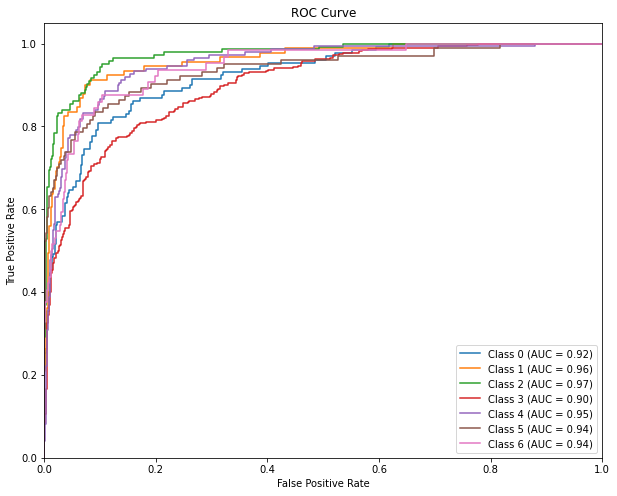

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def create_ROC_curves(model):
    out = model(dataset.data)
    probas = F.softmax(out, dim=1)
    pred = probas.argmax(dim=1)

    true_labels = dataset.data.y[dataset.data.test_mask].numpy()
    pred_labels = pred[dataset.data.test_mask].numpy()
    probas = probas[dataset.data.test_mask].detach().numpy()

    # Binarize the true labels for ROC curve calculation (OvR)
    true_labels_bin = label_binarize(true_labels, classes=list(range(7)))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(7):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
create_ROC_curves(model)

This is the ROC on the original model. It is interesting to note that the classes with the two highest accuracies from the confusion matrix (1 and 2) also have the highest AUC on the ROC curves.

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


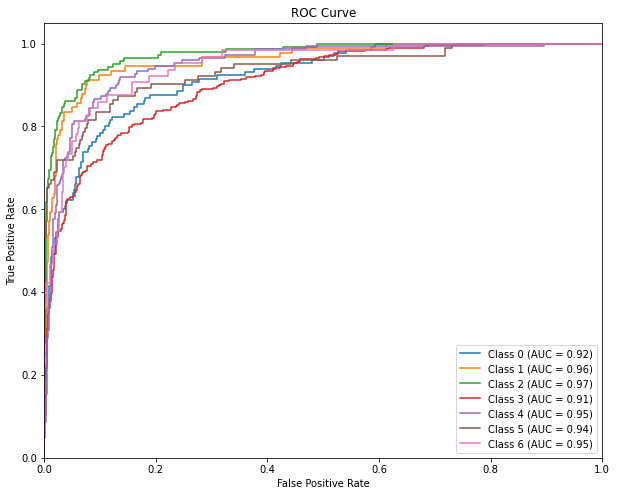

In [36]:
create_ROC_curves(model_drop10)

With 10% dropout, the model performed slightly better on the test set than the original model, increasing accuracy from 71.8% to 72.4%. The ROC curves are very similar to the initial model's ROC curves. It seems to be capturing each class about as well as the initial model. The AUC for each class is high across the board. Let's see if there are any differences by increasing the dropout.

In [23]:
model_drop20 = GraphSAGEDropout(dataset.num_node_features, dataset.num_classes, 0.2)
optimizer_drop20 = torch.optim.Adam(model_drop20.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_drop20 = []
for epoch in range(100):
    train(model_drop20, optimizer_drop20)
    accuracy_drop20.append(test(model_drop20))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_drop20[-1]}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.49
Accuracy on epoch 2: 0.62
Accuracy on epoch 3: 0.672
Accuracy on epoch 4: 0.7
Accuracy on epoch 5: 0.71
Accuracy on epoch 6: 0.718
Accuracy on epoch 7: 0.719
Accuracy on epoch 8: 0.718
Accuracy on epoch 9: 0.718
Accuracy on epoch 10: 0.722
Accuracy on epoch 11: 0.719
Accuracy on epoch 12: 0.715
Accuracy on epoch 13: 0.713
Accuracy on epoch 14: 0.714
Accuracy on epoch 15: 0.716
Accuracy on epoch 16: 0.714
Accuracy on epoch 17: 0.713
Accuracy on epoch 18: 0.712
Accuracy on epoch 19: 0.714
Accuracy on epoch 20: 0.711
Accuracy on epoch 21: 0.709
Accuracy on epoch 22: 0.711
Accuracy on epoch 23: 0.71
Accuracy on epoch 24: 0.711
Accuracy on epoch 25: 0.71
Accuracy on epoch 26: 0.711
Accuracy on epoch 27: 0.713
Accuracy on epoch 28: 0.713
Accuracy on epoch 29: 0.714
Accuracy on epoch 30: 0.714
Accuracy on epoch 31: 0.714
Accuracy on epoch 32: 0.717
Accuracy on epoch 33: 0.717
Accuracy on epoch 34: 0.718
Accuracy on epoch 35: 0.718
Accuracy on epoch 36: 0.718
Accuracy

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


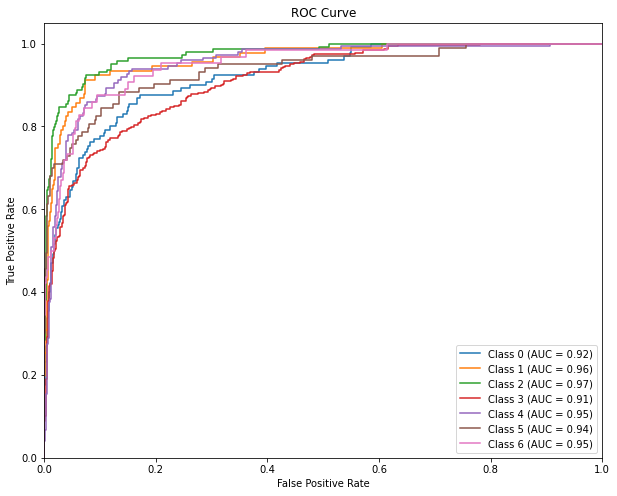

In [37]:
create_ROC_curves(model_drop20)

Accuracy on the test set slightly increased again, increasing to 73.4%. The ROC curves are once again very similar to the original model. It is good to know that with dropping out data from the training data, the model is still performing as well on each class as the initial model with all the training data.

In [25]:
model_drop50 = GraphSAGEDropout(dataset.num_node_features, dataset.num_classes, 0.5)
optimizer_drop50 = torch.optim.Adam(model_drop50.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_drop50 = []
for epoch in range(100):
    train(model_drop50, optimizer_drop50)
    accuracy_drop50.append(test(model_drop50))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_drop50[-1]}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.445
Accuracy on epoch 2: 0.581
Accuracy on epoch 3: 0.645
Accuracy on epoch 4: 0.678
Accuracy on epoch 5: 0.705
Accuracy on epoch 6: 0.727
Accuracy on epoch 7: 0.725
Accuracy on epoch 8: 0.724
Accuracy on epoch 9: 0.724
Accuracy on epoch 10: 0.722
Accuracy on epoch 11: 0.719
Accuracy on epoch 12: 0.717
Accuracy on epoch 13: 0.715
Accuracy on epoch 14: 0.715
Accuracy on epoch 15: 0.715
Accuracy on epoch 16: 0.712
Accuracy on epoch 17: 0.711
Accuracy on epoch 18: 0.708
Accuracy on epoch 19: 0.709
Accuracy on epoch 20: 0.709
Accuracy on epoch 21: 0.708
Accuracy on epoch 22: 0.711
Accuracy on epoch 23: 0.71
Accuracy on epoch 24: 0.709
Accuracy on epoch 25: 0.71
Accuracy on epoch 26: 0.709
Accuracy on epoch 27: 0.71
Accuracy on epoch 28: 0.711
Accuracy on epoch 29: 0.712
Accuracy on epoch 30: 0.712
Accuracy on epoch 31: 0.712
Accuracy on epoch 32: 0.711
Accuracy on epoch 33: 0.713
Accuracy on epoch 34: 0.712
Accuracy on epoch 35: 0.712
Accuracy on epoch 36: 0.714
Accu

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


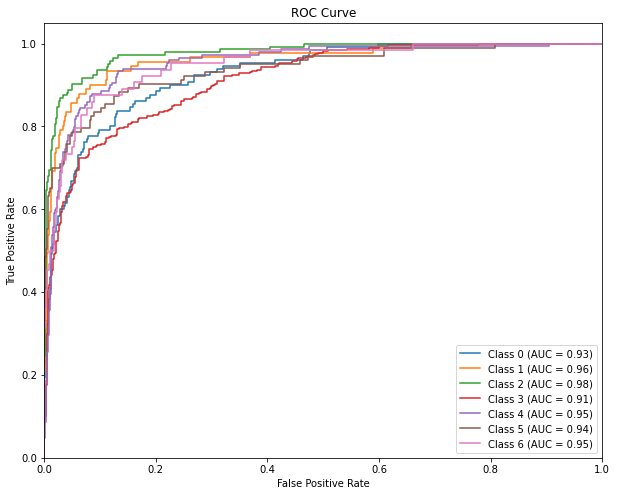

In [38]:
create_ROC_curves(model_drop50)

The accuracy on 50% dropout remained constant at 73.4%

In [27]:
model_drop75 = GraphSAGEDropout(dataset.num_node_features, dataset.num_classes, 0.75)
optimizer_drop75 = torch.optim.Adam(model_drop75.parameters(), lr=0.01, weight_decay=5e-4)

accuracy_drop75 = []
for epoch in range(100):
    train(model_drop75, optimizer_drop75)
    accuracy_drop75.append(test(model_drop75))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_drop75[-1]}')

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.318
Accuracy on epoch 2: 0.403
Accuracy on epoch 3: 0.531
Accuracy on epoch 4: 0.611
Accuracy on epoch 5: 0.648
Accuracy on epoch 6: 0.68
Accuracy on epoch 7: 0.685
Accuracy on epoch 8: 0.696
Accuracy on epoch 9: 0.706
Accuracy on epoch 10: 0.704
Accuracy on epoch 11: 0.709
Accuracy on epoch 12: 0.714
Accuracy on epoch 13: 0.717
Accuracy on epoch 14: 0.716
Accuracy on epoch 15: 0.721
Accuracy on epoch 16: 0.716
Accuracy on epoch 17: 0.716
Accuracy on epoch 18: 0.715
Accuracy on epoch 19: 0.716
Accuracy on epoch 20: 0.715
Accuracy on epoch 21: 0.714
Accuracy on epoch 22: 0.715
Accuracy on epoch 23: 0.723
Accuracy on epoch 24: 0.72
Accuracy on epoch 25: 0.725
Accuracy on epoch 26: 0.726
Accuracy on epoch 27: 0.729
Accuracy on epoch 28: 0.733
Accuracy on epoch 29: 0.735
Accuracy on epoch 30: 0.732
Accuracy on epoch 31: 0.73
Accuracy on epoch 32: 0.728
Accuracy on epoch 33: 0.73
Accuracy on epoch 34: 0.731
Accuracy on epoch 35: 0.731
Accuracy on epoch 36: 0.732
Accur

/home/mdalquist/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


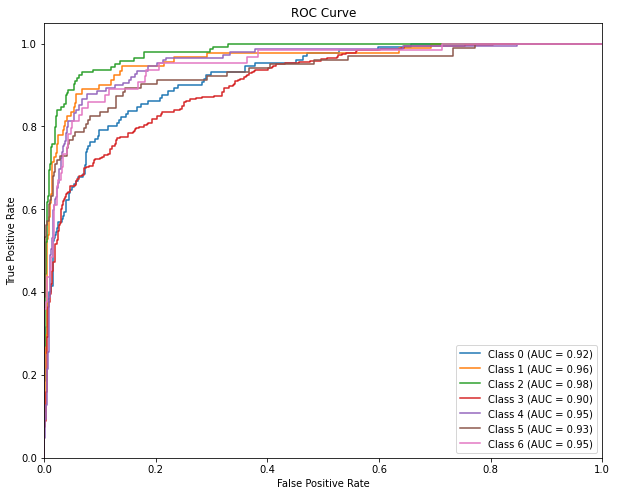

In [39]:
create_ROC_curves(model_drop75)

The accuracy with 75% dropout was 73.1%. Very slightly lower than the 20 and 50% dropout models, but still higher than the initial model. Also, the ROC curves remained very similar across the dropout models. This confirms that, even with dropout regularization taking away part of the training data, GraphSAGE can still do a good job making predictions, and it will maintain accuracy across classes.

#### Question 8:
Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.

The dataset I chose to use is the PPI (Protein-Protein Interaction) dataset also included in PyTorch Geometric Datasets. This dataset consists of multiple disjoint graphs, with each node representing a protein and each edge representing a biological interaction between them. Each node has a feature vector of length 50 containing positional gene sets, motif gene sets, and immunological signatures. There are 121 different labels representing different gene ontology sets the proteins are classified to. I will run GraphSAGE on this dataset to use the graph structure and node features to predict the class of each protein. With the different structure of the dataset, I had to change the loss function from NLL loss to Binary Cross Entropy loss. It does a better job of handling multi-label classification. I did this because there was an issue with the dimensionality of the output tensor while using F.nll_loss(), and it was resolved using nn.BCEWithLogitsLoss().

In [51]:
from torch_geometric.datasets import PPI

dataset_ppi = PPI(root='/tmp/PPI')

In [52]:
dataset_ppi.data

Data(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121])

In [53]:
train_dataset_ppi = PPI(root='/tmp/PPI', split='train')
test_dataset_ppi = PPI(root='/tmp/PPI', split='test')

train_loader = DataLoader(train_dataset_ppi, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset_ppi, batch_size=2, shuffle=False)

In [54]:
model_ppi = GraphSAGE(dataset_ppi.num_node_features, dataset_ppi.num_classes)
optimizer_ppi = torch.optim.Adam(model_ppi.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [55]:
def train_ppi(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)  
        loss = criterion(out, data.y.float())  
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Testing function
def test_ppi(model, test_loader):
    model.eval()
    total_correct = 0
    total_nodes = 0
    with torch.no_grad():
        for data in test_loader:  
            out = model(data) 
            pred = (out > 0).int()  
            total_correct += int((pred == data.y).sum()) 
            total_nodes += data.y.numel() 
    return total_correct / total_nodes  

In [ ]:
accuracy_ppi = []
for epoch in range(100):
    train_ppi(model_ppi, optimizer_ppi, train_loader)
    accuracy_ppi.append(test_ppi(model_ppi, test_loader))
    print(f'Accuracy on epoch {epoch+1}: {accuracy_ppi[-1]}')

Accuracy on epoch 1: 0.7006361422133919
Accuracy on epoch 2: 0.7006361422133919
Accuracy on epoch 3: 0.7006361422133919


I stopped the training after 3 epochs because each took about 10 minutes to run (much longer than the epochs for the other GraphSAGE models) and they each produced the same accuracy to 16 decimal places of precision. My theory on why this happened is because instead of each epoch building upon the training process from the last epoch, all the train data was used for training in the first epoch, then the process was repeated and started over for epochs 2 and 3. This produced the exact same results with test accuracy and not building upon the training process from the previous epoch. I probably messed this up, and I worked on this for a while until I reached this point where I'm stuck. I will meet with the instructors in office hours to improve my understanding of the dataset I chose, GraphSAGE, and the process of training neural networks. 